In [1]:
from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.general import *
from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *



In [9]:
def set_rectmask(inputarray, ymin, ymax, xmin, xmax):
    mask = np.zeros(np.shape(inputarray), dtype=inputarray.dtype)
    mask[ymin:ymax, xmin:xmax] = inputarray[ymin:ymax, xmin:xmax]
    return mask

In [3]:
### Create simulation phase error + Input phase spirals + Ideal intensity outputs
numpixels = 1920
numpixels_x = 1200
blank = np.empty((numpixels, numpixels),dtype=float)
ymin = numpixels // 2 - numpixels_x // 2
ymax = numpixels // 2 + numpixels_x // 2
xmin = 0
xmax = 1920

smooth_random_topology = create_smooth_random_topology(np.shape(blank), 50)
spiral1_phase = set_rectmask(opticalvortex(blank, 0,0,1,20,(2*np.pi)/15,650), ymin, ymax, xmin, xmax)
spiral2_phase = set_rectmask(opticalvortex(blank, 0,0,2,20,(2*np.pi)/15,650), ymin, ymax, xmin, xmax)
spiral3_phase = set_rectmask(opticalvortex(blank, 0,0,3,20,(2*np.pi)/15,650), ymin, ymax, xmin, xmax)

beamintensity = set_rectmask(np.ones(np.shape(blank)), ymin, ymax, xmin, xmax)

spiral1_target, spiral1_targetphase = fourier(beamintensity, spiral1_phase)
spiral2_target, spiral2_targetphase = fourier(beamintensity, spiral2_phase)
spiral3_target, spiral3_targetphase = fourier(beamintensity, spiral3_phase)


In [4]:
### Output the intensity pattern w/ errors added in
spiral1_distortedphase = (spiral1_phase + smooth_random_topology + np.pi) % (2*np.pi) - np.pi
spiral2_distortedphase = (spiral2_phase + smooth_random_topology + np.pi) % (2*np.pi) - np.pi
spiral3_distortedphase = (spiral3_phase + smooth_random_topology + np.pi) % (2*np.pi) - np.pi

spiral1_distortedtarget, spiral1_distortedtargetphase = fourier(beamintensity, spiral1_distortedphase)
spiral2_distortedtarget, spiral2_distortedtargetphase = fourier(beamintensity, spiral2_distortedphase)
spiral3_distortedtarget, spiral3_distortedtargetphase = fourier(beamintensity, spiral3_distortedphase)

In [10]:
### Retrieve simulation phase error
def modifiedGWSalgo3tar_rectmask(n_rep,target1, target2, target3, phase1, phase2, phase3, inputbeam, ymin, ymax, xmin, xmax):
    SIZE_X, SIZE_Y = np.shape(target1)
    inputbeam = set_rectmask(inputbeam, ymin, ymax, xmin, xmax)
    target_im1 = set_rectmask(target1, ymin, ymax, xmin, xmax)
    target_im2 = set_rectmask(target2, ymin, ymax, xmin, xmax)
    target_im3 = set_rectmask(target3, ymin, ymax, xmin, xmax)

    phaseguess1 = set_rectmask(phase1, ymin, ymax, xmin, xmax)
    phaseguess2 = set_rectmask(phase2, ymin, ymax, xmin, xmax)
    phaseguess3 = set_rectmask(phase3, ymin, ymax, xmin, xmax)

    # unknownphase = set_circlemask((2*np.pi*np.random.rand(SIZE_X,SIZE_Y)-np.pi)*0.5, radiusinput)
    unknownphase = set_rectmask(np.ones((SIZE_X,SIZE_Y))*0.7, ymin, ymax, xmin, xmax) * 0
    w1=np.ones((SIZE_X,SIZE_Y))
    w2=np.ones((SIZE_X,SIZE_Y))
    w3=np.ones((SIZE_X,SIZE_Y))
    w_prev1 = target_im1
    w_prev2 = target_im2
    w_prev3 = target_im3
    errors1=[]
    errors2=[]
    errors3=[]

    for rep in range(n_rep):
        inputphase1 = (phaseguess1+unknownphase + np.pi) %(2*np.pi) -np.pi
        inputphase2 = (phaseguess2+unknownphase + np.pi) %(2*np.pi) -np.pi
        inputphase3 = (phaseguess3+unknownphase + np.pi) %(2*np.pi) -np.pi

        
        input1 = join_phase_ampl(inputphase1, inputbeam)
        input2 = join_phase_ampl(inputphase2, inputbeam)
        input3 = join_phase_ampl(inputphase3, inputbeam)

        fftinput1 = sfft.fftshift(sfft.fft2(input1))
        fftinput2 = sfft.fftshift(sfft.fft2(input2))
        fftinput3 = sfft.fftshift(sfft.fft2(input3))

        # uscaled_atomplane = np.repeat(np.repeat(u_atomplane, precision, axis=0), precision, axis=1)
        fftintensity1 = np.square(np.abs(fftinput1))
        fftintensity2 = np.square(np.abs(fftinput2))
        fftintensity3 = np.square(np.abs(fftinput3))

        fftstdintensity1 = fftintensity1 /np.max(fftintensity1)
        fftstdintensity2 = fftintensity2 / np.max(fftintensity2)
        fftstdintensity3 = fftintensity3 / np.max(fftintensity3)

        fftphase1 = np.angle(fftinput1)
        fftphase2 = np.angle(fftinput2)
        fftphase3 = np.angle(fftinput3)

        threshold = 0.01
        errors1.append(np.sum((target_im1 - fftstdintensity1)[target_im1 > threshold]))
        errors2.append(np.sum((target_im2 - fftstdintensity2)[target_im2 > threshold]))
        errors3.append(np.sum((target_im3 - fftstdintensity3)[target_im3 > threshold]))

        w1[target1 > threshold] = np.sqrt(target_im1[target1 > threshold] / fftstdintensity1[target1 > threshold]) * w_prev1[target1 > threshold]
        w2[target2 > threshold] = np.sqrt(target_im2[target2 > threshold] / fftstdintensity2[target2 > threshold]) * w_prev2[target2 > threshold]
        w3[target3 > threshold] = np.sqrt(target_im3[target3 > threshold] / fftstdintensity3[target3 > threshold]) * w_prev3[target3 > threshold]

        w1 = w1 / np.max(w1)
        w2 = w2 / np.max(w2)
        w3 = w3 / np.max(w3)

        w_prev1 = w1
        w_prev2 = w2
        w_prev3 = w3
      
        input1 = sfft.ifft2(sfft.ifftshift(join_phase_ampl(fftphase1,w1)))
        input2 = sfft.ifft2(sfft.ifftshift(join_phase_ampl(fftphase2,w2)))
        input3 = sfft.ifft2(sfft.ifftshift(join_phase_ampl(fftphase3,w3)))

        input1 = set_rectmask(input1, ymin,ymax, xmin, xmax)
        input2 = set_rectmask(input2, ymin,ymax, xmin, xmax)
        input3 = set_rectmask(input3, ymin,ymax, xmin, xmax)

        
        inputphase1 = np.angle(input1)
        inputphase2 = np.angle(input2)
        inputphase3 = np.angle(input3)

        ## approx unknown phase here)
        unknownphase1 = (inputphase1 - phaseguess1 +np.pi) % (2*np.pi) - np.pi
        unknownphase2 = (inputphase2 - phaseguess2 +np.pi) % (2*np.pi) - np.pi
        unknownphase3 = (inputphase3 - phaseguess3 +np.pi) % (2*np.pi) - np.pi

        unknownphase = ((unknownphase1 + unknownphase2+unknownphase3) / 3 +np.pi) %(2*np.pi) - np.pi

        shifts = [(i, j) for i in range(-1, 2) for j in range(-1, 2)]
        shiftedarrays = [np.roll(unknownphase, shift, axis=(0, 1)) for shift in shifts]
        total_shiftedarrays = np.sum(shiftedarrays, axis=0)
        unknownphase = total_shiftedarrays / 9.0

        # unknownphase = np.mean([unknownphase1, unknownphase2, unknownphase3], axis=0)
        unknownphase = set_rectmask(unknownphase, ymin, ymax, xmin, xmax)
        # phase_slm=discretize_phase(phase_slm)
        # phase_slm = phase_slm
        # Final_ampl_phase = phase_slm
        # phase_slm=undiscretize_phase(phase_slm)
    
    return unknownphase, errors1, errors2,errors3, fftstdintensity1, fftstdintensity2,fftstdintensity3

retrievedphase, err1, err2, err3, int1, int2, int3 = modifiedGWSalgo3tar_rectmask(30, spiral1_distortedtarget, spiral2_distortedtarget, spiral3_distortedtarget, spiral1_phase, spiral2_phase, spiral3_phase, beamintensity, ymin, ymax, xmin, xmax)


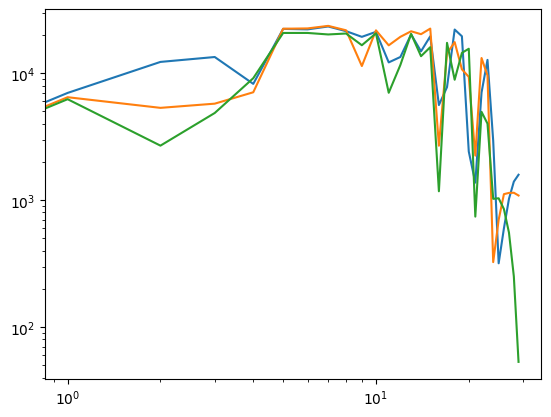

In [12]:
plt.loglog(err1, label="target 1")
plt.loglog(err2, label="target 2")
plt.loglog(err3, label="target 3")
plt.show()

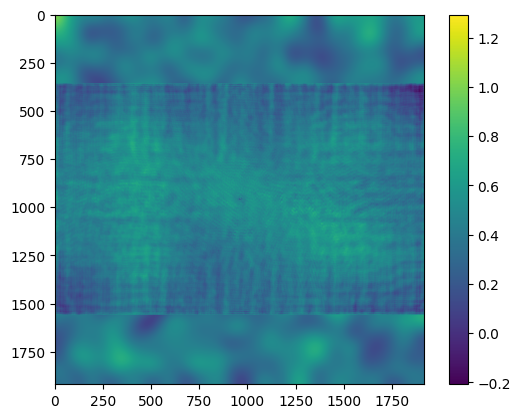

In [13]:
## Remove retrieved phase error from actual phase error (Meant to simulate actual process)
remainingphaseerror = (smooth_random_topology - retrievedphase + np.pi) % (2*np.pi) - np.pi
plt.imshow(remainingphaseerror)
plt.colorbar()


In [ ]:
## Repeat the cycle of intensity readout -> phase error retrieval
iterations = 3
for iteration in range(iterations):
    spiral1_phase = set_rectmask(spiral1_phase + remainingphaseerror, ymin, ymax, xmin, xmax)
    spiral2_phase = set_rectmask(spiral2_phase + remainingphaseerror, ymin, ymax, xmin, xmax)
    spiral3_phase = set_rectmask(spiral3_phase + remainingphaseerror,  ymin, ymax, xmin, xmax)
    #
    
    retrievedphase, err1, err2, err3, int1, int2, int3 = modifiedGWSalgo3tar_rectmask(30, spiral1_distortedtarget, spiral2_distortedtarget, spiral3_distortedtarget, spiral1_phase, spiral2_phase, spiral3_phase, beamintensity, ymin, ymax, xmin, xmax)



In [ ]:
### Calculate final calculated phase error and compare to real error



# Store calculated phase error for future application.